In [ ]:
###

# Use of External Libraries and Source Links:
# - pandas: https://pandas.pydata.org/
# - numpy: https://numpy.org/
# - matplotlib: https://matplotlib.org/
# - seaborn: https://seaborn.pydata.org/
# - scikit-learn: https://scikit-learn.org/
# - tensorflow: https://www.tensorflow.org/
# - keras api: https://keras.io/

###

In [ ]:
###    installs    ###    (please uncomment whichever one is necessary)

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scipy
# !pip install seaborn
# !pip install tensorflow
# !pip install --upgrade tensorflow
# !pip install librosa

In [ ]:
###    imports    ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import librosa
from keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [ ]:
###  set default theme  ###

sns.set_theme()

In [ ]:
# ###   mount data if using from drive   ###
# #
# # directory for the media folder and csv file (please provide the exact directory where the media folder and the csv file is located)
# # shared data 'media' shortcut created in directory - /content/drive/MyDrive/Colab Notebooks/)
# #
# ###

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


## Data Preprocessing and Features Engineering


In [ ]:
###   load csv   ###
csv_data = pd.read_csv('valid_data.csv').dropna()

# cleaning
csv_data['current_language'] = csv_data['current_language'].str.lower().str.strip()
csv_data['first_language'] = csv_data['first_language'].str.lower().str.strip()

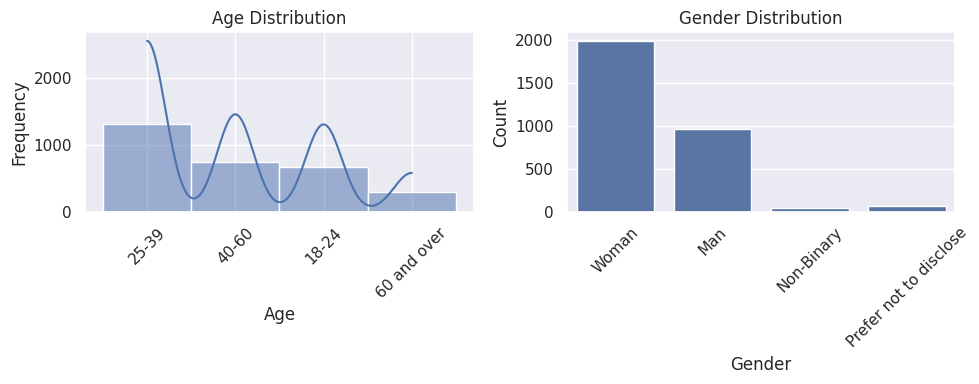

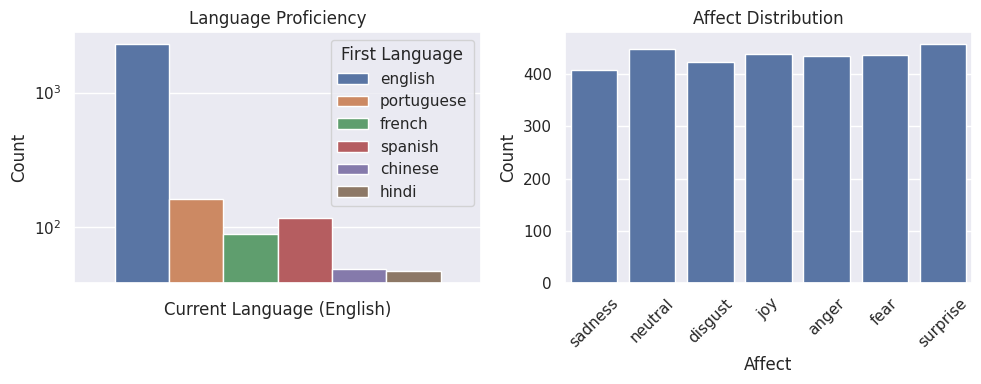

In [ ]:
###   visualize data   ###
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Age Distribution
sns.histplot(data=csv_data, x='age', bins=10, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Gender Distribution
sns.countplot(data=csv_data, x='gender', ax=axes[1])
axes[1].set_title('Gender Distribution')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plot 3: Language Proficiency
top_languages = csv_data['first_language'].value_counts().head(6)
english_data = csv_data[csv_data['current_language'] == 'english']
sns.countplot(data=english_data, x='current_language', hue='first_language', ax=axes[0], hue_order=top_languages.index)
axes[0].set_title('Language Proficiency')
axes[0].set_xlabel('Current Language (English)')
axes[0].set_ylabel('Count')
axes[0].legend(title='First Language')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_yscale('log')
axes[0].set_xticklabels([])

# Plot 4: Affect Distribution
sns.countplot(data=csv_data, x='affect', ax=axes[1])
axes[1].set_title('Affect Distribution')
axes[1].set_xlabel('Affect')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### **Load and extract from audio**

Features selection: MFCCs, pitch mean, energy, spectrogram, RMS energy, HNR ratio, chroma features, tempo, harmonic ratio, and spectral flux.
<br>

In [ ]:
###   Helper functions   ###

# 1. extract basic audio features (MFCC, Pitch Mean, Energy, Spectogram)
def extract_features(audio_data, sr):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    pitches, magnitudes = librosa.core.piptrack(y=audio_data, sr=sr)
    pitch_mean = np.mean(pitches)
    energy = np.sum(audio_data ** 2) / float(len(audio_data))
    spectrogram = np.abs(librosa.stft(audio_data))
    return mfccs, pitch_mean, energy, spectrogram

# 2. extract advanced features
#  (Root Mean Square (RMS) energ, Harmonic-to-Noise Ratio (HNR),
#  Chroma, Tempo, Harmonic Ratio, Sepctral Flux)
def extract_advanced_features(audio_data, sr):
    rms_energy = np.sqrt(np.mean(np.square(audio_data)))
    hnr = librosa.effects.harmonic(audio_data)
    hnr_ratio = np.mean(audio_data) / np.mean(hnr)
    chroma_features = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
    harmonic_ratio = np.sum(librosa.effects.harmonic(audio_data)**2) / np.sum(audio_data**2)
    spectral_flux = np.mean(librosa.onset.onset_strength(y=audio_data, sr=sr))

    return rms_energy, hnr_ratio, chroma_features, tempo, harmonic_ratio, spectral_flux

# 3. convert str to arr
def convert_to_float_array(string_array):
    try:
        return np.array([float(x) for x in string_array])
    except ValueError:
        return np.nan

# 4. parse
def parse_array_string(x):
    try:
        return np.fromstring(x[1:-1], sep=' ')
    except ValueError:
        print("Error parsing array string:", x)
        return np.nan

In [ ]:
###   load audio and extract features   ###

features_dict = {}
for index, row in csv_data.iterrows():
    file_name = row['file_name'].replace('.wav', '')
    full_file_path = file_name[1:] + row['chunk_name']
    sr = 22050

    if os.path.exists(full_file_path):
        audio_data, sr = librosa.load(full_file_path, sr=sr)
        # print(f"[Debug] Loaded audio file {full_file_path}. Shape: {audio_data.shape}")
        mfccs, pitch_mean, energy, spectrogram = extract_features(audio_data, sr)
        rms_energy, hnr_ratio, chroma_features, tempo, harmonic_ratio, spectral_flux = extract_advanced_features(audio_data, sr)

        features_dict[full_file_path] = {
            'mfccs': mfccs.flatten(),
            'pitch_mean': pitch_mean,
            'energy': energy,
            'spectrogram': spectrogram.flatten(),
            'rms_energy': rms_energy,
            'hnr_ratio': hnr_ratio,
            'chroma_features': chroma_features.flatten(),
            'tempo': tempo,
            'harmonic_ratio': harmonic_ratio,
            'spectral_flux': spectral_flux,
            'affect': row['affect'],
            'age': row['age'],
            'current_language': row['current_language'],
            'first_language': row['first_language'],
            'gender': row['gender'],
            'file_name': row['file_name'],
            'chunk_name': row['chunk_name']
        }
    else:
        # print(f"[Debug] Directory does not exist for audio file: {full_file_path}")
        continue

#Tracker: without caching time required ~90mins, ram required ~4.5gigs

In [ ]:
###   features df and save csv   ###
features_df = pd.DataFrame.from_dict(features_dict, orient='index')
features_df.to_csv('features_df.csv', index=False)

### X - y split

In [ ]:
###   load feature csv except for the first 100 data  ###
features_df = pd.read_csv('features_df.csv', skiprows=range(1, 100))

In [ ]:
###   split Xy, y will be the 100 anotated tests later   ###

features_df['mfccs'] = features_df['mfccs'].apply(parse_array_string)
features_df['spectrogram'] = features_df['spectrogram'].apply(parse_array_string)
features_df['chroma_features'] = features_df['chroma_features'].apply(parse_array_string)
features_df.dropna(subset=['mfccs', 'spectrogram', 'chroma_features'], inplace=True)

# use fixed length instead of max to avoid running out of ram
max_mfcc_length = max(len(mfccs) for mfccs in features_df['mfccs']) # 9035 - full data
max_spectrogram_length = max(spec.shape[0] for spec in features_df['spectrogram']) # 712375 - full data
max_chroma_length =max(len(chroma_features) for chroma_features in features_df['chroma_features']) # 8340 - full data
fixed_spectrogram_length = 5000
X_mfccs_padded = pad_sequences(features_df['mfccs'], maxlen=max_mfcc_length, dtype='float32', padding='post', truncating='post')
X_spectrogram_padded = pad_sequences(features_df['spectrogram'], maxlen=fixed_spectrogram_length, dtype='float32', padding='post', truncating='post')
X_chroma_padded = pad_sequences(features_df['chroma_features'], maxlen=max_chroma_length, dtype='float32', padding='post', truncating='post')

# covert fit and transform age, gender, lang
chroma_features = np.array(features_df['chroma_features'])
label_encoders = {}
for column in ['age', 'gender', 'current_language', 'first_language']:
    label_encoders[column] = LabelEncoder()
    features_df[column] = label_encoders[column].fit_transform(features_df[column])

# create X
X = np.concatenate((
    # X_mfccs_padded,
    np.array(features_df['pitch_mean'])[:, np.newaxis],
    np.array(features_df['energy'])[:, np.newaxis],
    np.array(features_df['rms_energy'])[:, np.newaxis],
    np.array(features_df['hnr_ratio'])[:, np.newaxis],
    np.array(features_df['tempo'])[:, np.newaxis],
    np.array(features_df['harmonic_ratio'])[:, np.newaxis],
    np.array(features_df['spectral_flux'])[:, np.newaxis],
    features_df['age'].values[:, np.newaxis],
    features_df['gender'].values[:, np.newaxis],
    features_df['current_language'].values[:, np.newaxis],
    features_df['first_language'].values[:, np.newaxis]
), axis=1)

y = features_df['affect']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)  #test size ~100

## ML Models - XGB


Classification Report:
              precision    recall  f1-score   support

       anger       0.09      0.20      0.13         5
     disgust       0.29      0.18      0.22        11
        fear       0.22      0.40      0.29         5
         joy       0.00      0.00      0.00         5
     neutral       0.45      0.50      0.48        10
     sadness       0.67      0.29      0.40        14
    surprise       0.27      0.30      0.29        10

    accuracy                           0.28        60
   macro avg       0.28      0.27      0.26        60
weighted avg       0.36      0.28      0.30        60

Accuracy: 0.2833333333333333


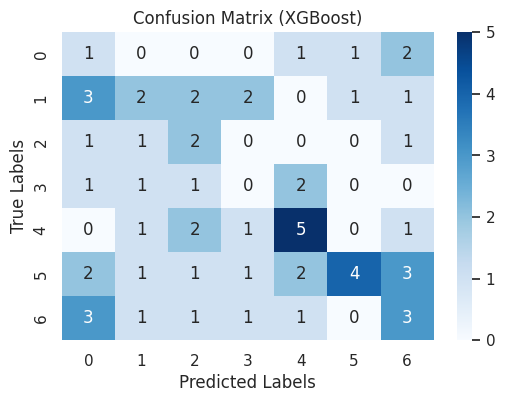

In [ ]:
# Encode
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(features_df['affect'])

# Model fit and predict
xgb_model = XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, n_estimators=50)
xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_decoded))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_decoded))
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb_decoded)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

### Cross - Validation

Cross-Validation Scores: [0.20379965 0.23834197 0.23529412 0.21107266 0.20069204]
Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         5
     disgust       0.22      0.18      0.20        11
        fear       0.00      0.00      0.00         5
         joy       0.11      0.20      0.14         5
     neutral       0.46      0.60      0.52        10
     sadness       0.50      0.21      0.30        14
    surprise       0.33      0.30      0.32        10

    accuracy                           0.25        60
   macro avg       0.23      0.21      0.21        60
weighted avg       0.30      0.25      0.26        60

Accuracy: 0.25


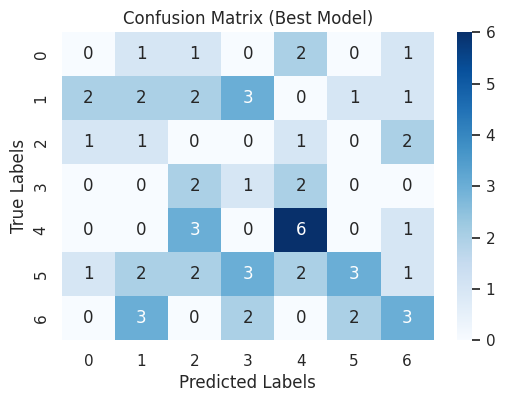

In [ ]:
###   performing 5 fold cv   ###
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(features_df['affect'])

xgb_model_cv = XGBClassifier(objective='multi:softmax', num_class=num_classes, n_estimators=250)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model_cv, X_train, y_train_encoded, cv=cv, scoring='accuracy')
best_fold_index = np.argmax(cv_scores)
print("Cross-Validation Scores:", cv_scores)

# Retrain the model
best_fold_data_indices = list(cv.split(X_train, y_train_encoded))[best_fold_index]
X_train_best_fold = X_train[best_fold_data_indices[0]]
y_train_best_fold = y_train_encoded[best_fold_data_indices[0]]
xgb_model_best = XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
xgb_model_best.fit(X_train_best_fold, y_train_best_fold)
y_pred_best_model = xgb_model_best.predict(X_test)
y_pred_best_model_decoded = label_encoder.inverse_transform(y_pred_best_model)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_best_model_decoded))
print("Accuracy:", accuracy_score(y_test, y_pred_best_model_decoded))
conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model_decoded)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best_model, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Model)')
plt.show()

### Hyper-parameters Tuning


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
39 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
 

Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

       anger       0.25      0.40      0.31         5
     disgust       0.33      0.18      0.24        11
        fear       0.12      0.20      0.15         5
         joy       0.11      0.20      0.14         5
     neutral       0.50      0.60      0.55        10
     sadness       0.83      0.36      0.50        14
    surprise       0.36      0.40      0.38        10

    accuracy                           0.35        60
   macro avg       0.36      0.33      0.32        60
weighted avg       0.44      0.35      0.36        60

Accuracy: 0.35


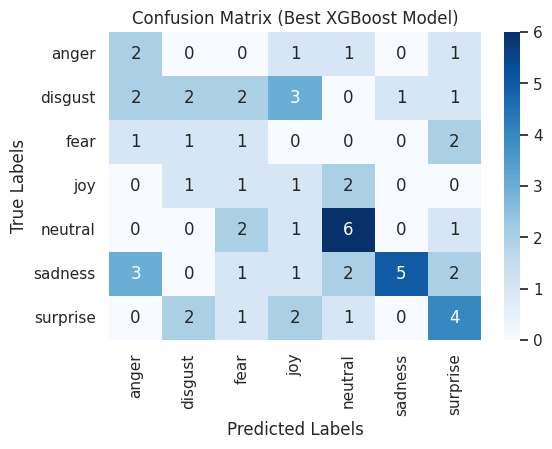

In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Parameters to test and model
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.6, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9, 1.0, 1.2],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}
xgb_model_tune = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes)

# Perform RandomizedSearchCV with cv 3 folds and find best hyper-parameters for model
random_search = RandomizedSearchCV(estimator=xgb_model_tune, param_distributions=param_grid,
                                   n_iter=50, scoring='accuracy', cv=3, verbose=1,
                                   random_state=42)
random_search.fit(X_train, y_train_encoded)
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred_encoded = best_model.predict(X_test)

# Decode and Evaluate
y_pred = label_encoder.inverse_transform(y_pred_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best XGBoost Model)')
plt.show()

## Tracker: time ~4m, ram ~1gig

### Other Models Test
Reason why GB was selected


In [ ]:
###   test few other models   ###
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

# Defining models
models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(n_estimators=10),
    "Voting Classifier": VotingClassifier(estimators=[
        ('gb', GradientBoostingClassifier(n_estimators=200)),
        ('svm', SVC(probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3))
    ]),
    "Multi-layer Perceptron": MLPClassifier(max_iter=200)
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Evaluation results for {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("-------------------------------------")

# Tracker: time ~20m, best model - GB, ram req ~5gig with spectogram

Training Gradient Boosting...
Evaluation results for Gradient Boosting:
Accuracy: 0.24193548387096775
-------------------------------------
Training Support Vector Machine...
Evaluation results for Support Vector Machine:
Accuracy: 0.14516129032258066
-------------------------------------
Training K-Nearest Neighbors...
Evaluation results for K-Nearest Neighbors:
Accuracy: 0.22580645161290322
-------------------------------------
Training Gaussian Naive Bayes...
Evaluation results for Gaussian Naive Bayes:
Accuracy: 0.06451612903225806
-------------------------------------
Training AdaBoost...
Evaluation results for AdaBoost:
Accuracy: 0.1774193548387097
-------------------------------------
Training Voting Classifier...
Evaluation results for Voting Classifier:
Accuracy: 0.22580645161290322
-------------------------------------
Training Multi-layer Perceptron...
Evaluation results for Multi-layer Perceptron:
Accuracy: 0.22580645161290322
-------------------------------------


## Evaluation on the Custom Annotated Test Data

In [ ]:
###   load audio and extract features for testing   ###

test = pd.read_csv('anot_test_bdey.csv')
features_dict_test_data = {}
for index, row in test.iterrows():
    file_name = row['file_name'].replace('.wav', '')
    full_file_path = file_name[1:] + row['chunk_name']
    sr = 22050

    if os.path.exists(full_file_path):
        audio_data, sr = librosa.load(full_file_path, sr=sr)
        mfccs, pitch_mean, energy, spectrogram = extract_features(audio_data, sr)
        rms_energy, hnr_ratio, chroma_features, tempo, harmonic_ratio, spectral_flux = extract_advanced_features(audio_data, sr)

        features_dict_test_data[full_file_path] = {
            'pitch_mean': pitch_mean,
            'energy': energy,
            'rms_energy': rms_energy,
            'hnr_ratio': hnr_ratio,
            'tempo': tempo,
            'harmonic_ratio': harmonic_ratio,
            'spectral_flux': spectral_flux,
            'affect': row['affect'],
            'age': row['age'],
            'current_language': row['current_language'],
            'first_language': row['first_language'],
            'gender': row['gender'],
            'file_name': row['file_name'],
            'chunk_name': row['chunk_name']
        }
    else:
        print(f"[Debug] Directory does not exist for audio file: {full_file_path}")

features_df_test_data = pd.DataFrame.from_dict(features_dict_test_data, orient='index')
label_encoders = {}
for column in ['age', 'gender', 'current_language', 'first_language']:
    label_encoders[column] = LabelEncoder()
    features_df_test_data[column] = label_encoders[column].fit_transform(features_df_test_data[column])

# create test
X_test_data = np.concatenate((
    np.array(features_df_test_data['pitch_mean'])[:, np.newaxis],
    np.array(features_df_test_data['energy'])[:, np.newaxis],
    np.array(features_df_test_data['rms_energy'])[:, np.newaxis],
    np.array(features_df_test_data['hnr_ratio'])[:, np.newaxis],
    np.array(features_df_test_data['tempo'])[:, np.newaxis],
    np.array(features_df_test_data['harmonic_ratio'])[:, np.newaxis],
    np.array(features_df_test_data['spectral_flux'])[:, np.newaxis],
    features_df_test_data['age'].values[:, np.newaxis],
    features_df_test_data['gender'].values[:, np.newaxis],
    features_df_test_data['current_language'].values[:, np.newaxis],
    features_df_test_data['first_language'].values[:, np.newaxis]
), axis=1)
y_test_data = features_df_test_data['affect']

Classification Report:
              precision    recall  f1-score   support

       anger       0.12      0.43      0.18         7
       angry       1.00      0.00      0.00         1
     disgust       0.18      0.13      0.15        15
        fear       0.20      0.07      0.10        15
         joy       0.00      0.00      0.00         8
     neutral       0.34      0.67      0.45        24
     sadness       0.00      0.00      0.00         9
    surprise       0.00      0.00      0.00        21

    accuracy                           0.22       100
   macro avg       0.23      0.16      0.11       100
weighted avg       0.16      0.22      0.16       100

Accuracy: 0.22


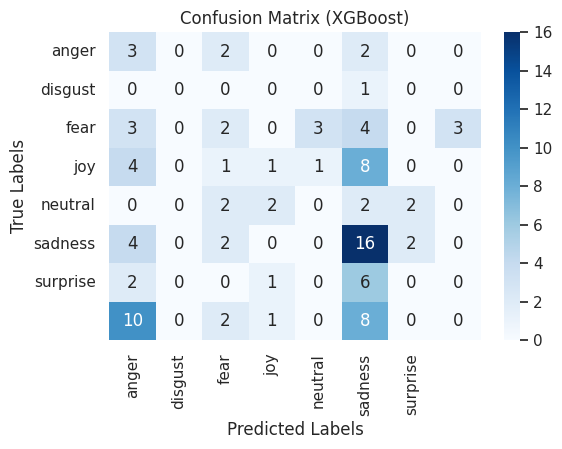

In [ ]:
###    Predict on test data    ###

best_model.fit(X_train, y_train_encoded)
y_pred_test_xgb = best_model.predict(X_test_data)
y_pred_test_xgb_decoded = label_encoder.inverse_transform(y_pred_test_xgb)
predictions_df = pd.DataFrame({'file_name': test['file_name'], 'chunk_name': test['chunk_name'], 'Predicted_Affect': y_pred_test_xgb_decoded})

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_data, y_pred_test_xgb_decoded, zero_division=1))
print("Accuracy:", accuracy_score(y_test_data, y_pred_test_xgb_decoded))
conf_matrix_xgb = confusion_matrix(y_test_data, y_pred_test_xgb_decoded)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

Classification Report:
              precision    recall  f1-score   support

       anger       0.29      0.29      0.29         7
       angry       1.00      0.00      0.00        10
     disgust       0.33      0.36      0.35        11
        fear       0.62      1.00      0.76        13
         joy       0.50      0.57      0.53         7
     neutral       0.52      0.44      0.48        25
     sadness       0.27      0.38      0.32         8
    surprise       0.45      0.47      0.46        19

    accuracy                           0.46       100
   macro avg       0.50      0.44      0.40       100
weighted avg       0.51      0.46      0.43       100

Accuracy: 0.46


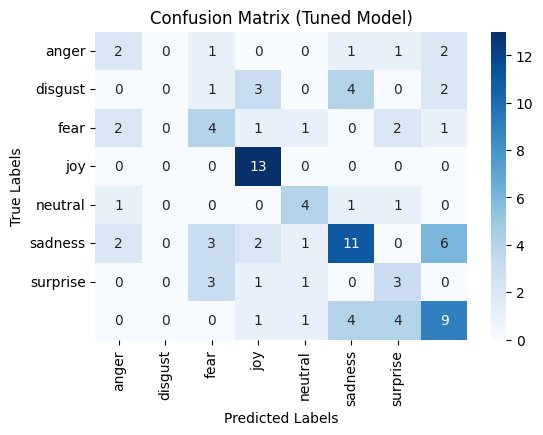

In [ ]:
###   using 2nd model   ###

best_model.fit(X_train, y_train_encoded)
y_pred_test_xgb = best_model.predict(X_test_data)
y_pred_test_xgb_decoded = label_encoder.inverse_transform(y_pred_test_xgb)
predictions_df = pd.DataFrame({'file_name': test['file_name'], 'chunk_name': test['chunk_name'], 'Predicted_Affect': y_pred_test_xgb_decoded})
print("Classification Report:")
print(classification_report(y_test_data, y_pred_test_xgb_decoded, zero_division=1))
print("Accuracy:", accuracy_score(y_test_data, y_pred_test_xgb_decoded))
conf_matrix_xgb = confusion_matrix(y_test_data, y_pred_test_xgb_decoded)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()

## ML Model - NN

Features like pitch_mean, energy, Root Mean Square (RMS) energy, Harmonic-to-Noise Ratio (HNR), Harmonic Ratio, and Spectral Flux could be more suitable for Recurrent Neural Networks (RNNs) because they capture temporal information. <br>


In [ ]:
###   RNN   ###

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Normalize data
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
scaler = StandardScaler()
X_train_rnn = scaler.fit_transform(X_train_rnn.reshape(-1, X_train_rnn.shape[-1])).reshape(X_train_rnn.shape)
X_test_rnn = scaler.transform(X_test_rnn.reshape(-1, X_test_rnn.shape[-1])).reshape(X_test_rnn.shape)

# Define RNN model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model.add(Dense(units=num_classes, activation='softmax'))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_rnn, y_train_encoded, epochs=500, batch_size=32,
                    validation_split=0.05, callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/500
86/86 [==============================] - 8s 9ms/step - loss: 1.9431 - accuracy: 0.1587 - val_loss: 1.9339 - val_accuracy: 0.1517
Epoch 2/500
86/86 [==============================] - 0s 3ms/step - loss: 1.9271 - accuracy: 0.1962 - val_loss: 1.9240 - val_accuracy: 0.1793
Epoch 3/500
86/86 [==============================] - 0s 3ms/step - loss: 1.9158 - accuracy: 0.2042 - val_loss: 1.9174 - val_accuracy: 0.1655
Epoch 4/500
86/86 [==============================] - 0s 3ms/step - loss: 1.9070 - accuracy: 0.2050 - val_loss: 1.9124 - val_accuracy: 0.1517
Epoch 5/500
86/86 [==============================] - 0s 3ms/step - loss: 1.9006 - accuracy: 0.2148 - val_loss: 1.9113 - val_accuracy: 0.1655
Epoch 6/500
86/86 [==============================] - 0s 3ms/step - loss: 1.8953 - accuracy: 0.2126 - val_loss: 1.9096 - val_accuracy: 0.1655
Epoch 7/500
86/86 [==============================] - 0s 3ms/step - loss: 1.8917 - accuracy: 0.2191 - val_loss: 1.9102 - val_accuracy: 0.1724
Epoch 8/500
8

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Limit TensorFlow to 4 CPU cores
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)


# Define a maximum length for padding (based on your dataset)
max_pad_length = 216

def extract_audio_features(file_path, max_pad_length):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load the audio file with its native sampling rate
        # Basic features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        # Concatenate all features
        features = np.concatenate((mfccs, chroma, mel, contrast, rolloff, centroid, zcr), axis=0)
        if features.shape[1] > max_pad_length:
            features = features[:, :max_pad_length]
        else:
            features = np.pad(features, pad_width=((0, 0), (0, max_pad_length - features.shape[1])), mode='constant')
        return features
    except Exception as e:
        # Return an array of zeros if there is an error
        return np.zeros((50, max_pad_length))  # Adjust zero array size based on the number of feature rows

# Load CSV and prepare data
csv_data = pd.read_csv('valid_data.csv')
features_list = []
labels = []
base_path = ""

for index, row in csv_data.iterrows():
    file_name = row['file_name'].replace('.wav', '')
    full_file_path = os.path.join(base_path, file_name[1:] + row['chunk_name'])
    features = extract_audio_features(full_file_path, max_pad_length)
    features_list.append(features)
    labels.append(row['affect'])

# Encoding labels
labels_encoded = LabelEncoder().fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Convert list of arrays to a 3D numpy array
features_array = np.stack(features_list, axis=0)

# Reshape for CNN input
features_array = features_array[..., np.newaxis]  # Add a channel dimension

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_categorical, test_size=0.2, random_state=42)

# Model definition using the Functional API
input_shape = X_train.shape[1:]  # Should be in the format (height, width, channels)
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary to check dimensions and parameters
model.summary()

# Train the model
model.fit(X_train, y_train, batch_size=16, epochs=60, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate



,mfccs,pitch_mean,energy,spectrogram,rms_energy,hnr_ratio,chroma_features,tempo,harmonic_ratio,spectral_flux,affect,age,current_language,first_language,gender,file_name,chunk_name
0,[-564.6596 -536.60175 -526.22656 ... ...,19.850279,0.005843,[2.82322709e-03 8.17765307e-04 5.00931870e-04 ...,0.076441,-5.017580,[0.20414224 0.06537554 0.04715328 ... 0.597702...,81.521739,0.770489,0.900427,sadness,25-39,english,english,Woman,/media/data/shout-data/shout_data_3afd7208-798...,/final/chunk42.wav
1,[-483.64255 -474.53604 -470.76962 ... 0. ...,43.602875,0.020044,[1.1172070e-02 4.2963633e-03 9.3973585e-04 ......,0.141575,21509.195000,[0.19564936 0.20278129 0.23364057 ... 0.826289...,133.928571,0.221997,1.086286,neutral,40-60,english,italian,Man,/media/data/shout-data/shout_data_ae6feb35-cf7...,/final/chunk20.wav
2,[-6.0872003e+02 -5.9884113e+02 -6.0879395e+02 ...,31.480888,0.001396,[0.02128842 0.01172928 0.00062174 ... 0.000490...,0.037364,6.134769,[0.28221157 0.19104373 0.24425128 ... 0.205289...,78.125000,0.100123,0.884229,neutral,18-24,english,english,Woman,/media/data/shout-data/shout_data_fdb758a5-9c8...,/final/chunk20.wav
3,[-6.8628912e+02 -6.5628082e+02 -6.4937054e+02 ...,35.468080,0.000179,[0.00229898 0.00480774 0.00149122 ... 0.000197...,0.013389,1.470209,[1. 0.8396719 0.8986306 ... 0.738681...,92.213115,0.337780,1.184959,neutral,18-24,english,english,Woman,/media/data/shout-data/shout_data_fdb758a5-9c8...,/final/chunk30.wav
4,[-5.0277191e+02 -4.9002240e+02 -4.9029749e+02 ...,11.792932,0.012742,[0.00362678 0.00097871 0.00303238 ... 0.000248...,0.112879,-23.026457,[0.17267597 0.11915903 0.10770002 ... 0.706597...,77.054795,0.730849,1.037656,disgust,25-39,english,english,Woman,/media/data/shout-data/shout_data_739dbf1c-ec2...,/final/chunk11.wav


In [ ]:
import pandas as pd
from statsmodels.stats.inter_rater import fleiss_kappa

# Load the CSV files
df1 = pd.read_csv('Converted_Self_Annotated_Wayne.csv')
df2 = pd.read_csv('Converted_Self_Annotated_Damanjit.csv')
df3 = pd.read_csv('anot_test.csv')

# Merge the DataFrames based on 'file_name' and 'chunk_name'
merged_df = df1.merge(df2, on=['file_name', 'chunk_name'], suffixes=['_rater1', '_rater2'])
merged_df = merged_df.merge(df3, on=['file_name', 'chunk_name'])
merged_df.rename(columns={'affect': 'affect_rater3'}, inplace=True)

# Create the count matrix
# Convert affect columns into a long format and then create a pivot table
long_format = merged_df.melt(id_vars=['file_name', 'chunk_name'], value_vars=['affect_rater1', 'affect_rater2', 'affect_rater3'],
                             var_name='rater', value_name='affect')
count_matrix = pd.crosstab(index=[long_format['file_name'], long_format['chunk_name']], columns=long_format['affect'])

# Ensure the matrix has the right shape
print("Count matrix:\n", count_matrix.head())

# Calculate Fleiss' Kappa
kappa_score = fleiss_kappa(count_matrix, method='uniform')
print("Fleiss' Kappa Score:", kappa_score)

FileNotFoundError: [Errno 2] No such file or directory: 'Converted_Self_Annotated_Wayne.csv'